In [1]:
import pandas as pd
from google.cloud import aiplatform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

In [2]:
! pip3 install db-dtypes

In [3]:
DATASET_URI = "gs://cloud-samples-data/vertex-ai/structured_data/forecasting/synthetic_sales_data.csv"

In [4]:
BUCKET_URI = "gs://lhl-final-project-assets-0013"

In [5]:
# Download the dataset
! gsutil cp {DATASET_URI} dataset.csv

Copying gs://cloud-samples-data/vertex-ai/structured_data/forecasting/synthetic_sales_data.csv...
/ [1 files][  1.6 MiB/  1.6 MiB]                                                
Operation completed over 1 objects/1.6 MiB.                                      


In [6]:
DATASET_TRAIN_FILENAME = "sales_forecasting_train.csv"
DATASET_TEST_FILENAME = "sales_forecasting_test.csv"
DATASET_TRAIN_URI = f"{BUCKET_URI}/{DATASET_TRAIN_FILENAME}"

In [7]:
# Load dataset
df = pd.read_csv("dataset.csv")

df["date"] = df["date"].astype("datetime64[ns]")

In [8]:
# Add a target column
df["product_at_store"] = df["product"] + " (" + df["store"] + ")"

# Split dataset into train and test by taking the first 90% of data for training.
dates_unique = df["date"].unique()
date_cutoff = sorted(dates_unique)[round(len(dates_unique) * 9 / 10)]

In [9]:
# Save train dataset
df[df["date"] < date_cutoff].to_csv(DATASET_TRAIN_FILENAME, index=False)

# Create test dataset
df_test = df[df["date"] >= date_cutoff]

# Upload to GCS bucket
! gsutil cp {DATASET_TRAIN_FILENAME} {DATASET_TRAIN_URI}

Copying file://sales_forecasting_train.csv [Content-Type=text/csv]...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


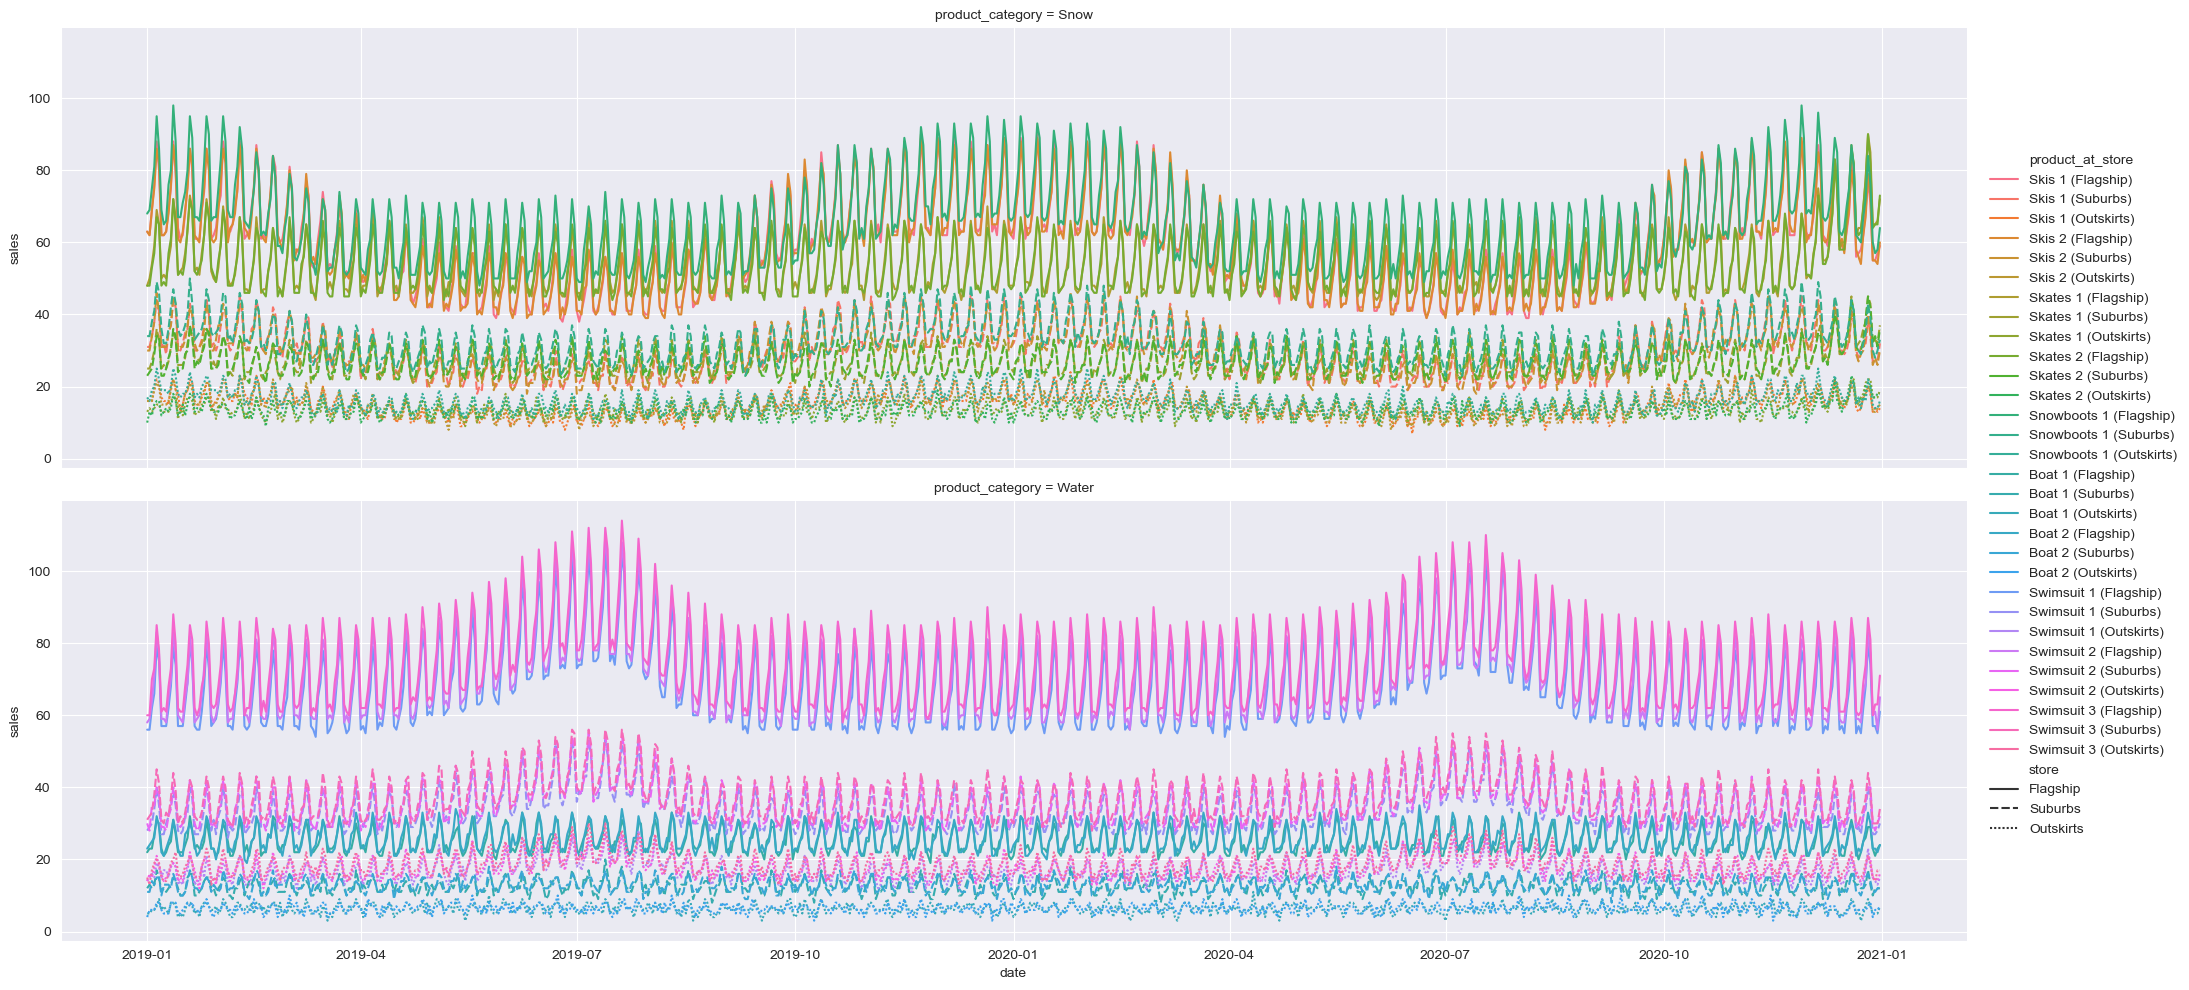

In [10]:
import seaborn as sns

sns.relplot(
    data=df,
    x="date",
    y="sales",
    hue="product_at_store",
    row="product_category",
    aspect=4,
    kind="line",
    style="store",
)

The seaborn `relplot` shown in the image is a multi-faceted line plot that visualizes the `sales` over time for different `product_at_store` combinations, grouped by `product_category` (Snow and Water). The plot provides several insights:

### Key Observations:

1. **Seasonal Patterns**:
   - Both `Snow` and `Water` product categories exhibit strong seasonal patterns, with sales peaking and dipping in a cyclical manner. 
   - The `Snow` category shows peaks during the winter months (as expected), indicating higher sales of snow-related products during this period.
   - The `Water` category shows a similar cyclical pattern, likely with peaks in warmer months when water-related products are in higher demand.

2. **Product-Specific Trends**:
   - Different `product_at_store` combinations (as shown by the various colored lines) have varying sales patterns, but all follow the overall seasonal trend. This suggests that while all products within a category are influenced by seasonality, there are differences in their specific performance.
   - Some products consistently have higher sales (those with higher peaks), while others have lower sales across the same periods.

3. **Store Location Impact**:
   - The line styles differentiate between different store locations (`Flagship`, `Suburbs`, and `Outskirts`). The patterns suggest that the location of the store also affects the sales trends:
     - Products in `Flagship` stores seem to have consistently higher sales compared to those in `Suburbs` and `Outskirts`.
     - This indicates that store location plays a significant role in sales performance, with central or flagship locations likely attracting more customers.

4. **Yearly Comparison**:
   - The plot spans multiple years, allowing for a comparison of the same periods across different years. The consistency of the patterns across years confirms the strong seasonal influence on sales.

5. **Category Differences**:
   - There is a visual difference between the `Snow` and `Water` categories in terms of the timing and magnitude of peaks. This further emphasizes the seasonal dependence of each product category and the importance of timing in sales strategies.

### Interpretation:

- **Seasonality**: The strong seasonal patterns suggest that forecasting models must account for seasonality to accurately predict sales for these products. The cyclic nature is evident for both Snow and Water products, aligned with their respective seasonal demand.
  
- **Store Strategy**: The impact of store location on sales performance should be considered in planning and inventory management. Flagship stores outperform others, which may inform decisions about stock distribution and promotional efforts.

- **Product-Specific Insights**: Some products perform consistently better than others within the same category. This information could guide marketing and sales strategies to focus on high-performing products during peak seasons.

- **Sales Optimization**: Understanding the specific timing and intensity of these sales peaks can help in optimizing inventory, staffing, and marketing efforts to align with expected demand surges.

### Actionable Insights:
- **Seasonal Planning**: Plan inventory and marketing strategies around these seasonal peaks to maximize sales.
- **Store-Specific Strategies**: Consider enhancing the product mix or promotional efforts in lower-performing store locations to boost sales.
- **Product Focus**: Focus on high-performing products during their peak seasons for better returns.

This `relplot` effectively visualizes the complex interplay between time, product type, store location, and sales, offering valuable insights into how to manage and optimize sales strategies.

In [11]:
dataset_time_series = aiplatform.TimeSeriesDataset.create(gcs_source=DATASET_TRAIN_URI)

print(dataset_time_series.resource_name)

Creating TimeSeriesDataset
Create TimeSeriesDataset backing LRO: projects/921277924119/locations/us-central1/datasets/8191360527419572224/operations/5261545940753317888
TimeSeriesDataset created. Resource name: projects/921277924119/locations/us-central1/datasets/8191360527419572224
To use this TimeSeriesDataset in another session:
ds = aiplatform.TimeSeriesDataset('projects/921277924119/locations/us-central1/datasets/8191360527419572224')
projects/921277924119/locations/us-central1/datasets/8191360527419572224


In [12]:
training_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name="hierachical_sales_forecasting02",
    optimization_objective="minimize-rmse",
    column_specs={
        "date": "timestamp",
        "sales": "numeric",
        "product_type": "categorical",
        "product_category": "categorical",
        "product": "categorical",
        "store": "categorical",
    },
)

In [13]:
# Each row represents a day, so we set context and time horizon to 30 to represent 30 days.

CONTEXT_WINDOW = 30
TIME_HORIZON = 30

In [14]:
time_column = "date"
time_series_identifier_column = "product_at_store"
target_column = "sales"

model = training_job.run(
    dataset=dataset_time_series,
    target_column=target_column,
    time_column=time_column,
    time_series_identifier_column=time_series_identifier_column,
    available_at_forecast_columns=[time_column],
    unavailable_at_forecast_columns=[target_column],
    time_series_attribute_columns=[
        "product_type",
        "product_category",
        "store",
        "product",
    ],
    forecast_horizon=TIME_HORIZON,
    data_granularity_unit="day",
    data_granularity_count=1,
    model_display_name="hierarchical_sales_forecasting_model",
    weight_column=None,
    hierarchy_group_columns=["product"],
    hierarchy_group_total_weight=10,
)

No dataset split provided. The service will use a default split.
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3050399744871366656?project=921277924119
AutoMLForecastingTrainingJob projects/921277924119/locations/us-central1/trainingPipelines/3050399744871366656 current state:
3
AutoMLForecastingTrainingJob projects/921277924119/locations/us-central1/trainingPipelines/3050399744871366656 current state:
3
AutoMLForecastingTrainingJob projects/921277924119/locations/us-central1/trainingPipelines/3050399744871366656 current state:
3
AutoMLForecastingTrainingJob projects/921277924119/locations/us-central1/trainingPipelines/3050399744871366656 current state:
3
AutoMLForecastingTrainingJob projects/921277924119/locations/us-central1/trainingPipelines/3050399744871366656 current state:
3
AutoMLForecastingTrainingJob projects/921277924119/locations/us-central1/trainingPipelines/3050399744871366656 current state:
3
AutoMLForecastingTrainingJob projec

The screenshot shows a model training job set up using Vertex AI’s AutoML Forecasting capabilities. Here’s a summary explaining the key aspects of this training job, including the rationale behind the chosen parameters:

### Model Training Job Overview:

This AutoML Forecasting training job is designed to build a machine learning model that can predict future sales based on historical sales data. The setup involves specifying the dataset, identifying key features, and configuring the model to optimize a specific objective, which in this case is minimizing the Root Mean Squared Error (RMSE).

### Key Parameters and Their Roles:

1. **Optimization Objective:**
   - **`optimization_objective="minimize-rmse"`**
   - **Why?**: RMSE (Root Mean Squared Error) is chosen as the optimization objective because it penalizes larger errors more than smaller ones, making it particularly useful for a forecasting model where the goal is to minimize significant prediction deviations. By minimizing RMSE, the model will be trained to make predictions that are closer to the actual sales values, especially focusing on reducing large errors.

2. **Column Specifications:**
   - **`column_specs`**: This parameter defines the data types for each column in the dataset:
     - **`date`**: A timestamp column that captures the date of the sales record.
     - **`sales`**: The numeric target variable that the model aims to predict.
     - **`product_type`, `product_category`, `product`, `store`**: Categorical features that provide context about the type of product and the store where sales occurred. These are key to capturing the different factors that influence sales.
   - **Why?**: Specifying the correct data types helps the AutoML model understand how to handle each column during training, ensuring that categorical variables are treated differently from numeric ones, and that the date is properly utilized for temporal analysis.

3. **Context Window and Time Horizon:**
   - **`CONTEXT_WINDOW = 30`**
   - **`TIME_HORIZON = 30`**
   - **Why?**: The context window is set to 30 days, meaning the model uses the previous 30 days of data to predict the next 30 days (time horizon). This configuration is common in sales forecasting, where a month’s worth of historical data is often a good indicator of the following month’s sales, capturing short-term seasonal effects and trends.

4. **Time Series Configuration:**
   - **`time_column="date"`**: The column that identifies the time aspect of the data.
   - **`time_series_identifier_column="product_at_store"`**: A unique identifier combining the product and store, ensuring the model tracks sales patterns separately for each product at each store.
   - **`target_column="sales"`**: The column containing the sales figures that the model is predicting.
   - **Why?**: Properly setting the time column and time series identifier ensures that the model treats the data as a time series, where the sequence of data points matters, and predictions are made for each unique product-store combination.

5. **Time Series Attribute Columns:**
   - **`time_series_attribute_columns`**: Includes features like `product_type`, `product_category`, `store`, and `product`.
   - **Why?**: These features are used by the model to understand how different attributes affect sales. For instance, different product categories or store types may have distinct sales patterns that the model can learn and incorporate into its predictions.

6. **Forecast Horizon and Granularity:**
   - **`forecast_horizon=TIME_HORIZON`**: Forecasts are made 30 days into the future.
   - **`data_granularity_unit="day"`**: The data is aggregated at the daily level.
   - **Why?**: Setting the forecast horizon to 30 days matches the time horizon, ensuring that the model predicts the next 30 days. Daily granularity is essential for capturing detailed sales trends and daily fluctuations.

7. **Hierarchy Grouping:**
   - **`hierarchy_group_columns=["product"]`** and **`hierarchy_group_total_weight=10`**
   - **Why?**: Hierarchical grouping allows the model to make predictions not just at the individual product level but also to consider the aggregated performance across similar products. This can improve the model’s ability to generalize and make robust predictions across different levels of product granularity.

### Summary:
This Vertex AI AutoML Forecasting job is carefully configured to predict sales by considering various factors such as product type, store location, and daily sales patterns. The key decisions, like optimizing for RMSE and setting a 30-day context window and time horizon, are made to ensure that the model accurately captures and predicts the temporal dynamics of sales data. The use of hierarchical grouping and detailed column specifications further enhances the model's ability to provide accurate and actionable forecasts.

### Model Training Results
![Model Training Results](../images/model_training_results.png "Model Training Results")

In [15]:
# Get evaluations
model_evaluations = model.list_model_evaluations()

model_evaluation = list(model_evaluations)[0]
print(model_evaluation)

resource name: projects/921277924119/locations/us-central1/models/844733892899373056@1/evaluations/8180490234047812075


***Results***

| Property             | Value                              |
|----------------------|------------------------------------|
| **Name**             | untitled_4182544601245554303       |
| **Status**           | Succeeded                          |
| **Evaluation dataset** | –                                |
| **Created**          | Aug 8, 2024, 7:17:30 PM            |
| **MAE**              | 1.202                              |
| **MAPE**             | 5.327                              |
| **R-squared**        | 0.993                              |
| **RMSE**             | 1.721                              |
| **RMSLE**            | 0.07                               |
| **RMSPE**            | 8.191                              |
| **WAPE**             | 3.788                              |


In [16]:
import numpy as np

# Store start and end dates for context and horizon
date_context_window_start = date_cutoff
date_context_window_end = date_cutoff + np.timedelta64(CONTEXT_WINDOW, "D")
time_horizon_end = date_context_window_end + np.timedelta64(TIME_HORIZON, "D")

# Extract dataframes for context and horizon
df_test_context = df_test[
    (df_test["date"] >= date_context_window_start)
    & (df_test["date"] < date_context_window_end)
]
df_test_horizon = df_test[
    (df_test["date"] >= date_context_window_end) & (df_test["date"] < time_horizon_end)
].copy()

# Save a copy for validation of predictions
df_test_horizon_actual = df_test_horizon.copy()

# Remove sales for horizon (i.e. future dates)
df_test_horizon["sales"] = ""

# Write test data to CSV
df_test = pd.concat([df_test_context, df_test_horizon])
df_test.to_csv(DATASET_TEST_FILENAME, index=False)

# Save test dataset
DATASET_TEST_URI = f"{BUCKET_URI}/{DATASET_TEST_FILENAME}"

# Upload to GCS bucket
! gsutil cp {DATASET_TEST_FILENAME} {DATASET_TEST_URI}

Copying file://sales_forecasting_test.csv [Content-Type=text/csv]...
/ [1 files][162.8 KiB/162.8 KiB]                                                
Operation completed over 1 objects/162.8 KiB.                                    


In [17]:
df_test_context.head()

,date_index,product_index,store_index,date,day_of_week,temperature,product,product_type,product_category,store,sales,product_at_store
19740,658,0,0,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Flagship,61.0,Skis 1 (Flagship)
19741,658,0,1,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Suburbs,31.0,Skis 1 (Suburbs)
19742,658,0,2,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Outskirts,15.0,Skis 1 (Outskirts)
19743,658,1,0,2020-10-20,1,7.164706,Skis 2,Skis,Snow,Flagship,61.0,Skis 2 (Flagship)
19744,658,1,1,2020-10-20,1,7.164706,Skis 2,Skis,Snow,Suburbs,28.0,Skis 2 (Suburbs)


In [18]:
df_test_horizon.head()

,date_index,product_index,store_index,date,day_of_week,temperature,product,product_type,product_category,store,sales,product_at_store
20640,688,0,0,2020-11-19,3,5.080392,Skis 1,Skis,Snow,Flagship,,Skis 1 (Flagship)
20641,688,0,1,2020-11-19,3,5.080392,Skis 1,Skis,Snow,Suburbs,,Skis 1 (Suburbs)
20642,688,0,2,2020-11-19,3,5.080392,Skis 1,Skis,Snow,Outskirts,,Skis 1 (Outskirts)
20643,688,1,0,2020-11-19,3,5.080392,Skis 2,Skis,Snow,Flagship,,Skis 2 (Flagship)
20644,688,1,1,2020-11-19,3,5.080392,Skis 2,Skis,Snow,Suburbs,,Skis 2 (Suburbs)


### Create a results dataset

Create a BigQuery dataset to store the prediction results.

In [19]:
PROJECT_ID = "lhl-final-project-431618"

In [20]:
from google.cloud import bigquery

# Create client in default region
bigquery_client = bigquery.Client(
    project=PROJECT_ID,
    credentials=aiplatform.initializer.global_config.credentials,
)

In [21]:
def create_bigquery_dataset(name: str, region: str):
    batch_predict_bq_output_uri_prefix = "bq://{}.{}".format(PROJECT_ID, name)

    bq_dataset = bigquery.Dataset("{}.{}".format(PROJECT_ID, name))

    dataset_region = region
    bq_dataset.location = dataset_region
    bq_dataset = bigquery_client.create_dataset(bq_dataset)
    print(
        "Created bigquery dataset {} in {}".format(
            batch_predict_bq_output_uri_prefix, dataset_region
        )
    )

    return batch_predict_bq_output_uri_prefix

In [22]:
REGION = "us-central1"  # @param {type: "string"}

In [24]:
batch_predict_bq_output_uri_prefix = create_bigquery_dataset(
    name="hierarchical_forecasting_unique", region=REGION
)

Created bigquery dataset bq://lhl-final-project-431618.hierarchical_forecasting_unique in us-central1


In [25]:
batch_prediction_job = model.batch_predict(
    job_display_name="hierarchical_forecasting_unique",
    gcs_source=DATASET_TEST_URI,
    instances_format="csv",
    bigquery_destination_prefix=batch_predict_bq_output_uri_prefix,
    predictions_format="bigquery",
    generate_explanation=True,
    sync=True,
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/921277924119/locations/us-central1/batchPredictionJobs/8945963500820234240
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/921277924119/locations/us-central1/batchPredictionJobs/8945963500820234240')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/8945963500820234240?project=921277924119
BatchPredictionJob projects/921277924119/locations/us-central1/batchPredictionJobs/8945963500820234240 current state:
3
BatchPredictionJob projects/921277924119/locations/us-central1/batchPredictionJobs/8945963500820234240 current state:
3
BatchPredictionJob projects/921277924119/locations/us-central1/batchPredictionJobs/8945963500820234240 current state:
3
BatchPredictionJob projects/921277924119/locations/us-central1/batchPredictionJobs/8945963500820234240 current state:
3
BatchPredictionJob projects/9212779241

### Vertex AI batch prediction job results
![Batch Prediction Job Results](../images/batch_prediction_screenshot.png "Batch Prediction Job Results")

###  View the batch prediction results

Use the BigQuery Python client to query the destination table and return results as a Pandas dataframe.

In [26]:
# View the results as a dataframe
df_output = batch_prediction_job.iter_outputs(bq_max_results=1000).to_dataframe()

# Convert the dates to the datetime64 datatype
df_output["date"] = df_output["date"].astype("datetime64[ns]")

# Extract the predicted sales and convert to floats
df_output["predicted_sales"] = (
    df_output["predicted_sales"].apply(lambda x: x["value"]).astype(float)
)

df_output.head()

,date,explanation,predicted_on_date,predicted_sales,product,product_at_store,product_category,product_type,sales,store
0,2020-11-19,{'attributions': [{'featureAttributions': {'da...,2020-11-19,12.196157,Boat 1,Boat 1 (Suburbs),Water,Boat,None,Suburbs
1,2020-11-20,{'attributions': [{'featureAttributions': {'da...,2020-11-19,13.042915,Boat 1,Boat 1 (Suburbs),Water,Boat,None,Suburbs
2,2020-11-21,{'attributions': [{'featureAttributions': {'da...,2020-11-19,15.355120,Boat 1,Boat 1 (Suburbs),Water,Boat,None,Suburbs
3,2020-11-22,{'attributions': [{'featureAttributions': {'da...,2020-11-19,14.228952,Boat 1,Boat 1 (Suburbs),Water,Boat,None,Suburbs
4,2020-11-23,{'attributions': [{'featureAttributions': {'da...,2020-11-19,10.948827,Boat 1,Boat 1 (Suburbs),Water,Boat,None,Suburbs


### Compare predictions vs ground truth

Plot the predicted sales vs the ground truth

/var/folders/3s/6lw377616q34kygz2k067bcr0000gn/T/ipykernel_60303/12094010.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_prediction_comparison = pd.concat([df_output, df_test_horizon_actual])
/Users/kiddstudio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/kiddstudio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 2400x1200 with 0 Axes>

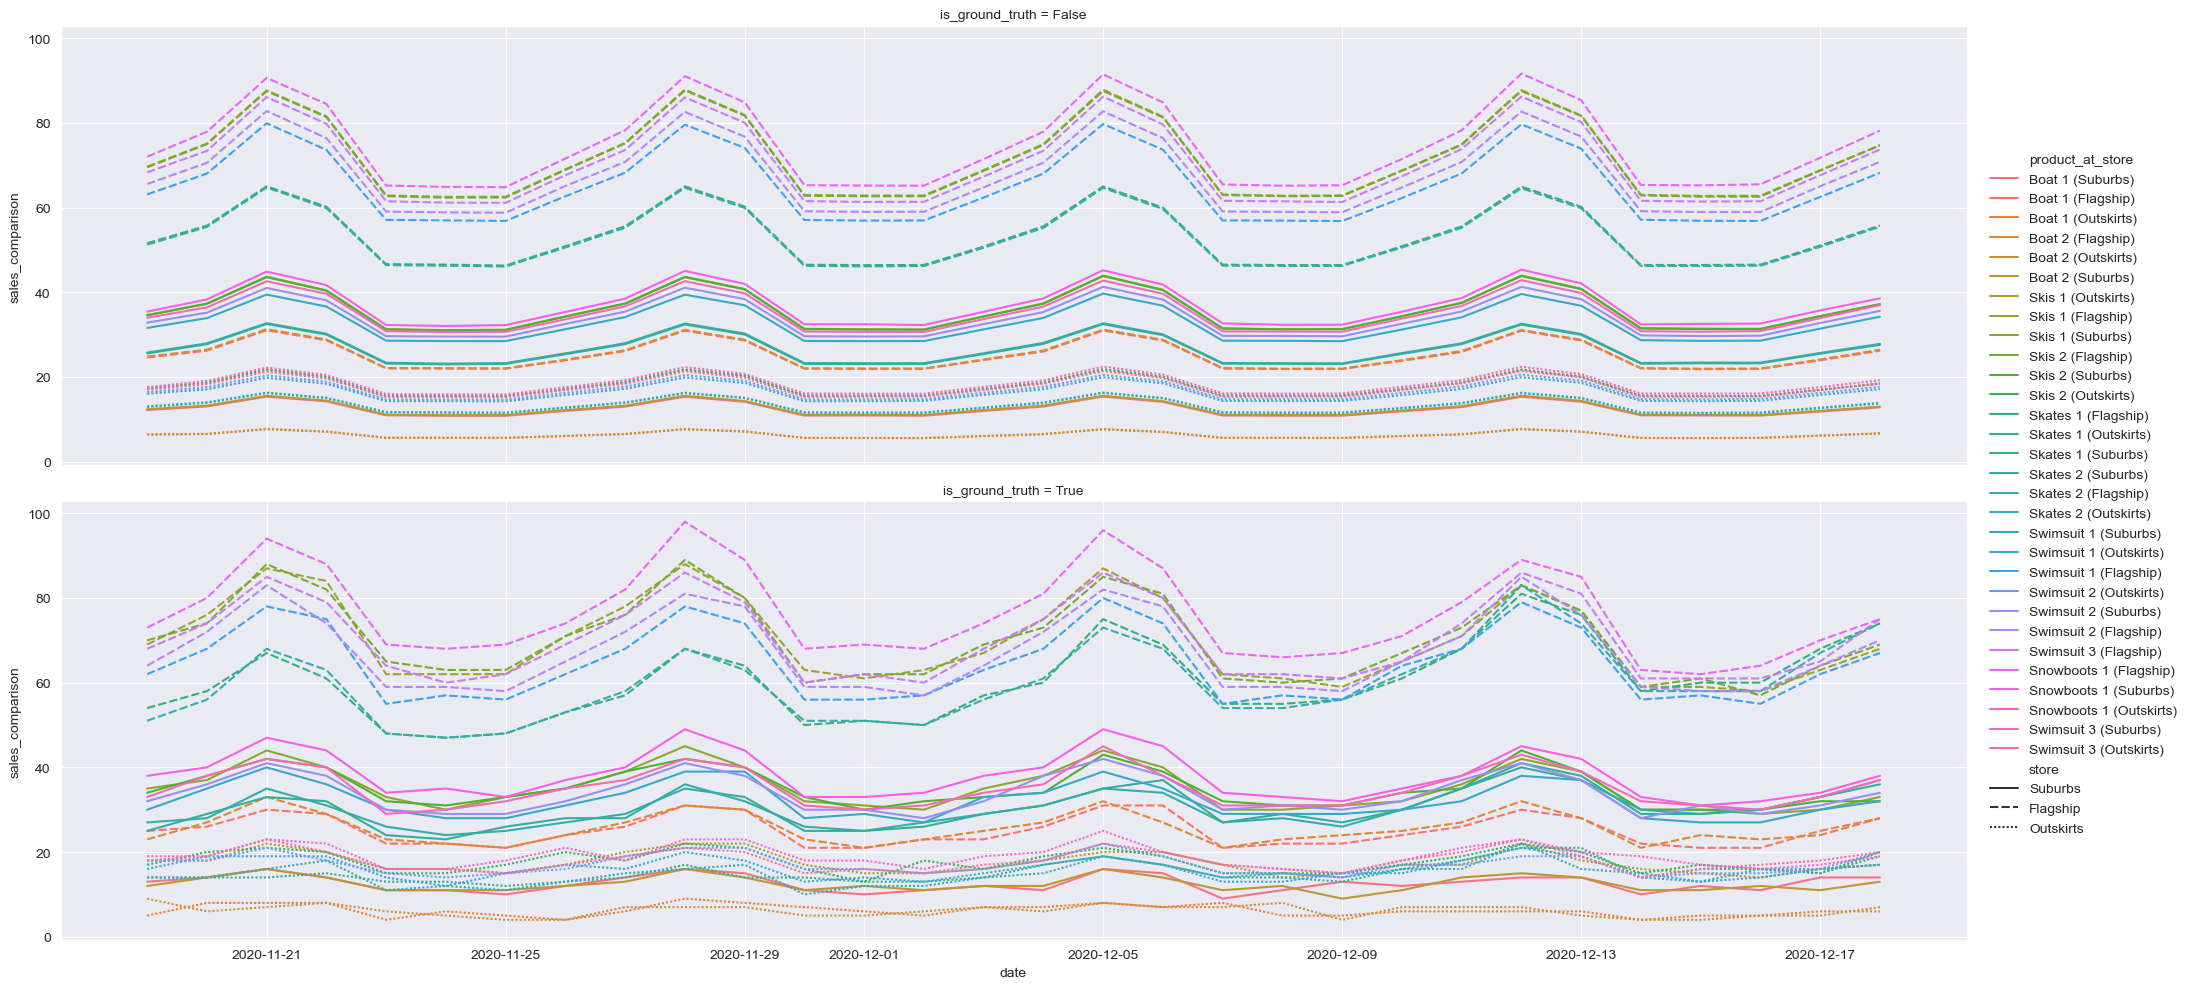

In [27]:
import matplotlib.pyplot as plt

# Create a shared dataframe to plot predictions vs ground truth
df_output["sales_comparison"] = df_output["predicted_sales"]
df_output["is_ground_truth"] = False
df_test_horizon_actual["sales_comparison"] = df_test_horizon_actual["sales"]
df_test_horizon_actual["is_ground_truth"] = True
df_prediction_comparison = pd.concat([df_output, df_test_horizon_actual])

# Plot sales
fig = plt.gcf()
fig.set_size_inches(24, 12)

sns.relplot(
    data=df_prediction_comparison,
    x="date",
    y="sales_comparison",
    hue="product_at_store",
    style="store",
    row="is_ground_truth",
    height=5,
    aspect=4,
    kind="line",
    ci=None,
)

The plot you've provided compares the predicted sales (`is_ground_truth = False`) versus the actual sales (`is_ground_truth = True`) for different products at various store locations over time. Here's what we can gather from this comparison:

### Key Observations:

1. **Overall Pattern Consistency**:
   - The overall patterns in both the ground truth and predicted sales data are quite similar. The peaks and troughs align well between the two plots, suggesting that the model is capturing the general seasonal and temporal trends in sales data effectively.

2. **Differences in Magnitude**:
   - Although the patterns are similar, there are noticeable differences in the magnitude of sales between the predictions and the ground truth. In some cases, the predictions are slightly higher or lower than the actual sales.
   - For example, the predicted sales for some products (e.g., `Skis` and `SwimSuit`) appear to be consistently overestimated or underestimated compared to the ground truth. This suggests that while the model captures trends well, it may not always predict the exact sales volume accurately.

3. **Product-Specific Accuracy**:
   - The accuracy of predictions seems to vary across different products. Some products, like `Skates` and `Snowboots`, show a close match between predicted and actual sales, while others have more noticeable discrepancies.
   - This variation might indicate that the model performs better for certain product categories or at certain store locations than others.

4. **Temporal Consistency**:
   - Both the predicted and actual sales data show consistency over the same time periods, which is a good indication that the model correctly identifies when sales peaks and declines are likely to occur.

5. **Store Location Impact**:
   - The dotted lines representing different store locations (`Flagship`, `Suburbs`, `Outskirts`) show similar patterns in both the ground truth and predictions, but there are some differences in the exact heights of the lines. This might suggest that the model could be slightly overfitting or underfitting for specific locations.

### Interpretation:

- **Model Strengths**:
  - The model does a good job of capturing the overall trend and seasonality in sales data, which is crucial for effective forecasting.
  - It is particularly effective in maintaining temporal consistency, predicting when peaks and troughs will occur.

- **Areas for Improvement**:
  - The differences in the magnitude of predictions versus the ground truth suggest that the model might benefit from further fine-tuning. This could involve adjusting model parameters, improving feature selection, or incorporating additional data to enhance accuracy.
  - Addressing product-specific discrepancies could involve more detailed modeling for different product categories or using separate models for different products if necessary.

- **Store Location Consideration**:
  - The variation in prediction accuracy across different store locations suggests that more granular modeling might be required, potentially accounting for location-specific factors that influence sales.

### Actionable Steps:

- **Model Fine-Tuning**: Consider refining the model by adjusting hyperparameters or using more sophisticated models to improve accuracy, especially in terms of the magnitude of predictions.
- **Feature Engineering**: Explore additional features or more detailed modeling for specific products or store locations to reduce discrepancies.
- **Post-Modeling Analysis**: Use techniques like residual analysis to identify where and why the model is underperforming and to make necessary adjustments.

Overall, the comparison shows that your model is generally on the right track but could benefit from further refinement to achieve more accurate sales predictions.